In [1]:
import h5py
import torch
import torch.nn as nn
import random


import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
# import skfuzzy as fuzz

In [2]:
from torch.utils.data import DataLoader, TensorDataset

In [3]:
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
print(FILE_PATH)

c:\Users\AT30890\Hoctap\Hprediction\H_est_cGAN\Channel_Estimation_cGAN_new\Channel_Estimation_cGAN\Torch_code


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Constants
file_path = os.path.join(FILE_PATH, '..', 'DeepMIMOv2', 'Gan_Data', 'Doppler_shift', 'freq_symb_1ant_612sub', 'Gan_0_dBOutdoor1_60_1ant_612subcs.mat')

file_path = os.path.normpath(file_path)

BATCH_SIZE = 64  # Batch size

NUM_EPOCHS = 5

file = h5py.File(file_path, 'r')

In [6]:
type(BATCH_SIZE)

int

In [6]:
# pytorch: [batchsize, channels, height, width]

In [7]:
input_data = file['input_da']
input_data.shape
output_data = file['output_da']
output_data.shape

(1647, 612, 14, 2, 1)

In [8]:
Hreal = np.array(file['output_da'])
Hreal = torch.tensor(Hreal)                # Nsamples x 612 x 14 x 2 x 1 (antenna_BS)
Hreal = Hreal.permute(0,3,1,2,4).squeeze() # 612 x 14 x 2 x Nsamples

# Y
input_data = np.array(file['input_da'])
input_data = torch.tensor(input_data)                # Nsamples x 612 x 14 x 2 x 1 (antenna_BS)
input_data = input_data.permute(0,3,1,2,4).squeeze() # 612 x 14 x 2 x Nsamples

input_data.shape

torch.Size([1647, 2, 612, 14])

In [9]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData   = torch.cat((input_data[:,0,:,:], input_data[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels = torch.cat((Hreal[:,0,:,:], Hreal[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)

trainData.shape

torch.Size([3294, 1, 612, 14])

In [10]:
# Split into training and validation sets
valData   = trainData[0:BATCH_SIZE,:,:,:].to(device, dtype=torch.float)
valLabels = trainLabels[0:BATCH_SIZE,:,:,:].to(device, dtype=torch.float)

trainData   = trainData[BATCH_SIZE:,:,:,:].to(device, dtype=torch.float)
trainLabels = trainLabels[BATCH_SIZE:,:,:,:].to(device, dtype=torch.float)

print(valData.shape)
print(trainData.shape)

torch.Size([64, 1, 612, 14])
torch.Size([3230, 1, 612, 14])


In [11]:
# Validate roughly 5 times every epoch
valFrequency = round(trainData.size(0)/BATCH_SIZE/5); 

In [12]:
class CNN_Est(nn.Module):
    def __init__(self):
        super(CNN_Est, self).__init__()
        
        self.normalization = nn.BatchNorm2d(1)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.relu  = nn.ReLU() 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        # Forward pass
        out = self.normalization(x)
        out = self.conv1(x)
        out = self.relu(out)  
        out = self.conv2(out)
        out = self.relu(out)  
        out = self.conv3(out)
        out = self.relu(out)  
        out = self.conv4(out)
        out = self.relu(out) 
        out = self.conv5(out)
        return out

In [13]:
model = CNN_Est().to(device)
print(model)

CNN_Est(
  (normalization): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [14]:
# Create a DataLoader for your dataset
dataset = TensorDataset(trainData, trainLabels)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(valData, valLabels)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

In [16]:
# Training loop
train_loss =[]
vali_loss = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
    
    # Validation 
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            running_val_loss += val_loss.item()
    avg_val_loss = running_val_loss / len(val_loader)
    vali_loss.append(avg_val_loss)    
            
    print(f" Val Loss: {avg_val_loss}")


Epoch 1/10, Loss: 2.4879971169755163e-05 
 Val Loss: 5.070341444479709e-07
Epoch 2/10, Loss: 2.019307626208983e-07 
 Val Loss: 1.1775344432862767e-07
Epoch 3/10, Loss: 2.464604101109502e-07 
 Val Loss: 1.2562743734179094e-07
Epoch 4/10, Loss: 1.2088311033645974e-07 
 Val Loss: 7.376109323331548e-08
Epoch 5/10, Loss: 6.622082124482297e-08 
 Val Loss: 6.07439076816263e-08
Epoch 6/10, Loss: 5.6642990637770066e-08 
 Val Loss: 5.2906464986790525e-08
Epoch 7/10, Loss: 2.3422619862828343e-07 
 Val Loss: 5.9521742201695815e-08
Epoch 8/10, Loss: 5.457359705752763e-08 
 Val Loss: 4.2976125769200735e-08
Epoch 9/10, Loss: 3.9513697899730114e-08 
 Val Loss: 3.6674649095402856e-08
Epoch 10/10, Loss: 3.440782668806106e-08 
 Val Loss: 3.218166710894366e-08


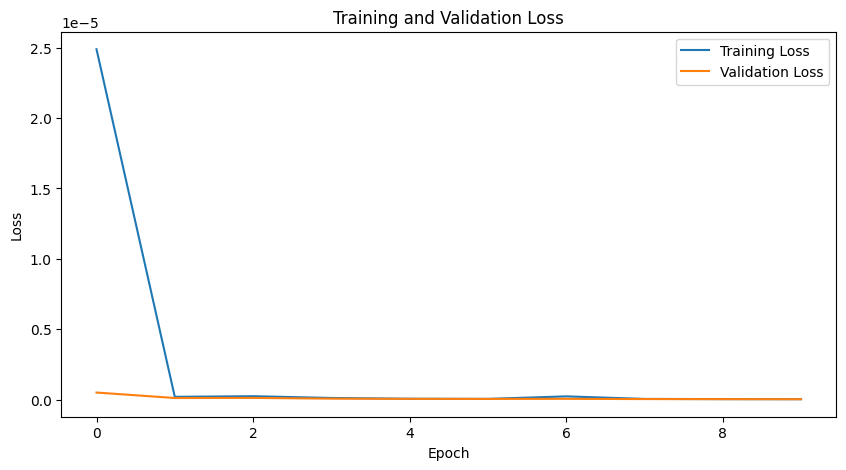

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(vali_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [41]:
val_outputs.shape

torch.Size([64, 1, 612, 14])

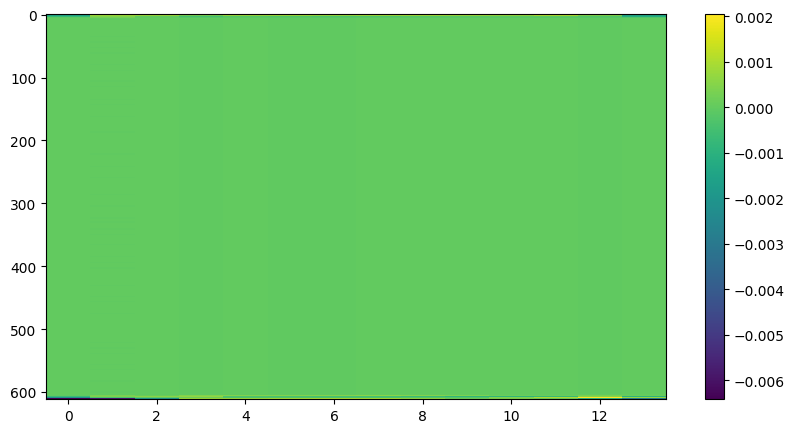

In [18]:
H_estimate = val_outputs.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_estimate[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

Code above:  straightly used Y to estimate H

For better:  Use Y./X to estimate H

Even better: Use lineearInterpolate(Y.X) to estimate H